#Gathering required packages

In [ ]:
! pip install tensorflow_text
! pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 115.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 49.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fo

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

 99% 1.00M/1.01M [00:00<00:00, 1.08MB/s]
100% 1.01M/1.01M [00:00<00:00, 1.09MB/s]


In [ ]:
! unzip /content/hate-speech-and-offensive-language-dataset.zip

Archive:  /content/hate-speech-and-offensive-language-dataset.zip
  inflating: labeled_data.csv        


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import tensorflow_text
import matplotlib.pyplot as plt


#EXPLORATORY DATA ANALYSIS

In [ ]:
data=pd.read_csv("labeled_data.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [ ]:
data = data[["class","tweet"]]
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
data.rename(columns={"class":"offensive"},inplace=True)
data.head()

,offensive,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


#DATA CLEANING

In [ ]:
import re
import string
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
#    tweet_tokens = word_tokenize(text)
#    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return text

In [ ]:
data.tweet = data.tweet.apply(clean)

In [ ]:
data.offensive.value_counts()

1    19190
2     4163
0     1430
Name: offensive, dtype: int64

#*Class*
0 - hate speech

1 - offensive language

2 - neither

#FEATURE ENGINEERING

In [ ]:
data.offensive.unique()

array([2, 1, 0])

In [ ]:
data.loc[data['offensive'] == 2, 'offensive'] = 0
data.offensive.value_counts()

1    19190
0     5593
Name: offensive, dtype: int64

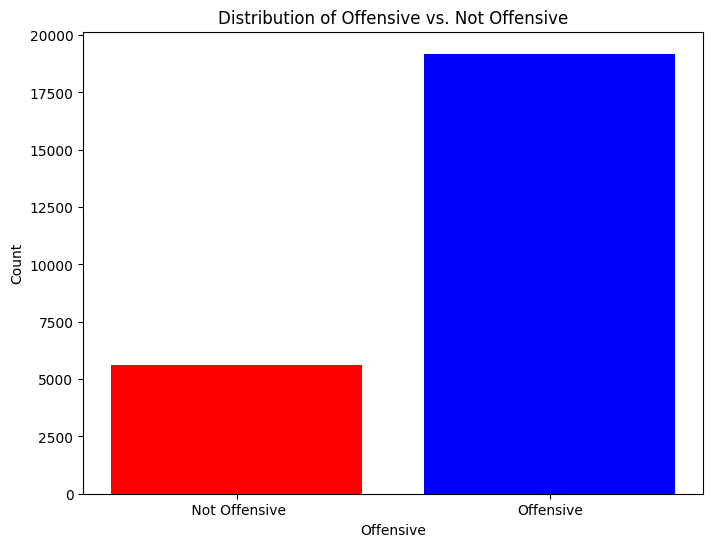

In [ ]:
value_counts = data['offensive'].value_counts()


plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values, color=['blue', 'red'])
plt.xlabel('Offensive')
plt.ylabel('Count')
plt.xticks(value_counts.index, ['Offensive', ' Not Offensive'])
plt.title('Distribution of Offensive vs. Not Offensive')
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler

X = data['tweet']
y = data['offensive']

# Initialize the RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Apply the oversampler to balance the dataset
X_resampled, y_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with balanced data
balanced_df = pd.DataFrame({'tweet': X_resampled.ravel(), 'offensive': y_resampled})

# Check the class distribution in the balanced DataFrame
class_distribution = balanced_df['offensive'].value_counts()
print(class_distribution)

0    19190
1    19190
Name: offensive, dtype: int64


In [ ]:
balanced_df

,tweet,offensive
0,rt mayasolovely as a woman you shouldnt compl...,0
1,rt boy dats coldtyga dwn bad for cuffin dat ...,1
2,rt urkindofbrand dawg rt you ever fuck a bit...,1
3,rt cganderson vivabased she look like a tranny,1
4,rt shenikaroberts the shit you hear about me ...,1
...,...,...
38375,wish i had a brownie or a dab to knock me out rn,0
38376,philhughes yankees nyy better then ur whole team,0
38377,f u tumblr bc my blog is black amp white but t...,0
38378,whos downie like a brownie brunch need mimosas,0


In [ ]:
balanced_df.tweet.duplicated().value_counts()

False    24669
True     13711
Name: tweet, dtype: int64

BALANCING THE DATA

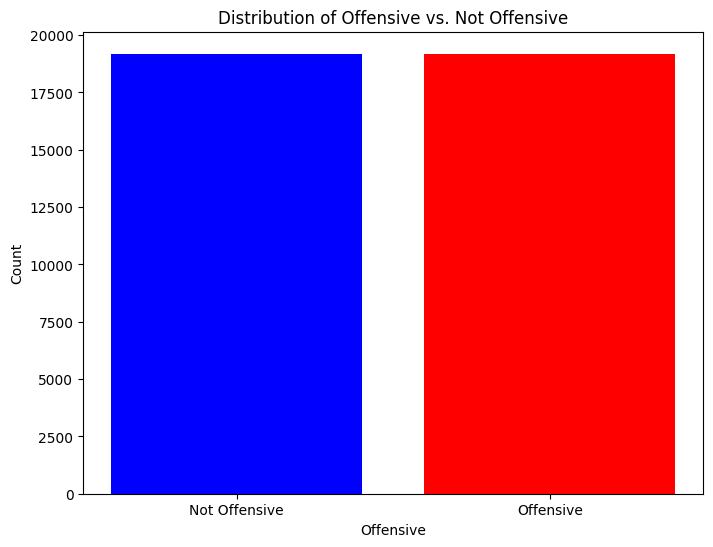

In [ ]:
value_counts = balanced_df['offensive'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(value_counts.index, value_counts.values, color=['blue', 'red'])
plt.xlabel('Offensive')
plt.ylabel('Count')
plt.xticks(value_counts.index, ['Not Offensive', 'Offensive'])
plt.title('Distribution of Offensive vs. Not Offensive')
plt.show()

In [ ]:
# Split the data into training (60%), validation (20%), and testing (20%) sets
train_df, test_val_df = train_test_split(balanced_df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (23028, 2)
Validation set shape: (7676, 2)
Test set shape: (7676, 2)


In [ ]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_df['tweet'].values, train_df['offensive'].values)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['tweet'].values, val_df['offensive'].values)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['tweet'].values, test_df['offensive'].values)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#CREATING A MODEL

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
text_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime

model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

callbacks = [tensorboard_callback]


#TRAINING THE MODEL

In [ ]:
history1=model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=callbacks)

Epoch 1/10
720/720 [==============================] - 361s 495ms/step - loss: 0.5338 - accuracy: 0.7390 - precision: 0.7345 - recall: 0.7509 - val_loss: 0.5138 - val_accuracy: 0.7546 - val_precision: 0.7341 - val_recall: 0.7851
Epoch 2/10
720/720 [==============================] - 359s 499ms/step - loss: 0.5269 - accuracy: 0.7467 - precision: 0.7441 - recall: 0.7541 - val_loss: 0.5078 - val_accuracy: 0.7572 - val_precision: 0.7364 - val_recall: 0.7880
Epoch 3/10
720/720 [==============================] - 355s 494ms/step - loss: 0.5211 - accuracy: 0.7483 - precision: 0.7452 - recall: 0.7567 - val_loss: 0.5022 - val_accuracy: 0.7619 - val_precision: 0.7437 - val_recall: 0.7866
Epoch 4/10
720/720 [==============================] - 358s 498ms/step - loss: 0.5162 - accuracy: 0.7560 - precision: 0.7540 - recall: 0.7621 - val_loss: 0.4982 - val_accuracy: 0.7629 - val_precision: 0.7527 - val_recall: 0.7710
Epoch 5/10
720/720 [==============================] - 354s 491ms/step - loss: 0.5149 - a

#VISUALISING THE TRAINING AND VALIDATION HISTORY

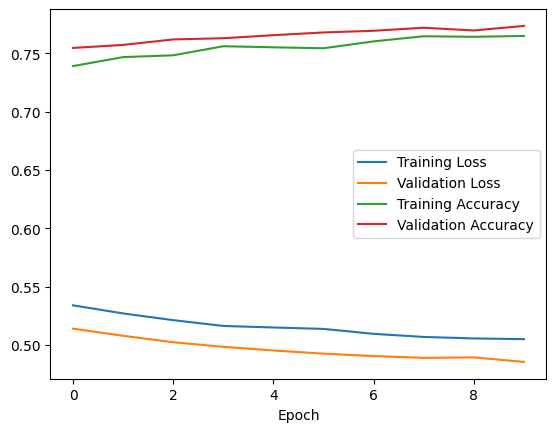

In [ ]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')

# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "training vs validation" \
  --description "Comparing training and validation evaluation results" \
  --one_shot

#EVALUATING THE MODEL

In [ ]:
model.evaluate(test_dataset)

240/240 [==============================] - 84s 349ms/step - loss: 0.4816 - accuracy: 0.7791 - precision: 0.7700 - recall: 0.8010


[0.4815938174724579, 0.7790516018867493, 0.7699950337409973, 0.801033616065979]

In [ ]:
predicted=model.predict(test_df.tweet)

240/240 [==============================] - 88s 363ms/step


In [ ]:
predicted=np.round(predicted)

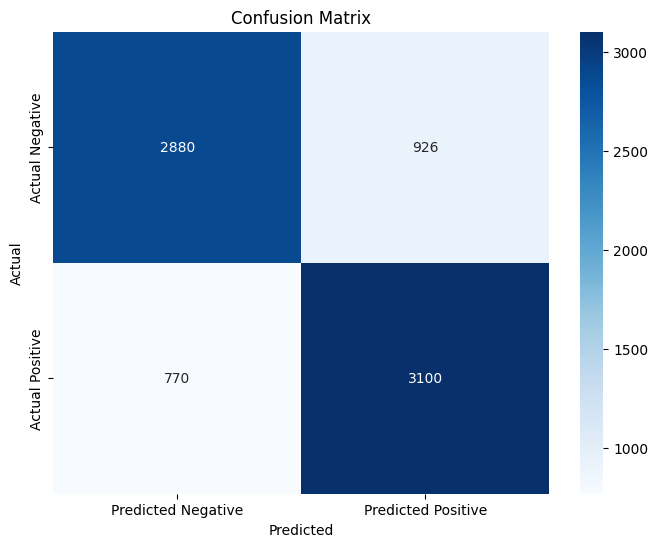

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_df.offensive,predicted)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(test_df.offensive, predicted)

print(report)

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      3806
           1       0.77      0.80      0.79      3870

    accuracy                           0.78      7676
   macro avg       0.78      0.78      0.78      7676
weighted avg       0.78      0.78      0.78      7676



#SAVING THE MODEL

In [ ]:
model.save("model1.h5")

In [ ]:
loaded_model=tf.keras.models.load_model('model1')

In [ ]:
loaded_model.predict(["you are a bitch"])

1/1 [==============================] - 0s 161ms/step


array([[0.8547743]], dtype=float32)

In [ ]:
import shutil

folder_name = 'model1'


shutil.make_archive(folder_name, 'zip', folder_name)


'/content/model1.zip'

In [ ]:
from google.colab import files


files.download('model1.zip')

#USING THE MODEL FOR FURTHER LINGUISTICSENSITIVITY UPGRADE

In [ ]:
from itertools import combinations

def get_subsets_of_size_n(arr, n):
    return list(combinations(arr, n))


def remove_items_from_array(a, b):
    return [item for item in a if item not in b]

def replace_items(list1, list2):
    return ['*' * len(item) if item in list2 else item for item in list1]

def process_text(text,sensitivity=0.6):
    data=[]
    text=text.split(".")

    for sentence in text:

      offensive_score = loaded_model.predict([sentence])

      if offensive_score > sensitivity:
        n=0
        while offensive_score > sensitivity:
            words = sentence.split()
            n+=1
            subsets=get_subsets_of_size_n(words,n)
            #print(subsets,n)
            for subset in subsets:
              test_sent=" ".join(remove_items_from_array(words,subset))
              offensive_score = loaded_model.predict([test_sent])

              if offensive_score < sensitivity:
                data.append(" ".join(replace_items(words,subset)))
                break
      else: data.append(sentence)

    return ".".join(data)

#WORKING EXAMPLE

In [ ]:
input_text = "fuck you are a bitch.But still a good guy."
print("Input text : ",input_text)
output_text = process_text(input_text,0.6)
print("Output text : ",output_text)

Input text :  fuck you are a bitch.But still a good guy.
1/1 [==============================] - 0s 128ms/step
Output text :  **** you are a *****.But still a good guy.


#Referances

In [ ]:
tf.__version__

'2.13.0'